In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from jax.example_libraries.optimizers import adam as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 12
NN_SHAPES = jnp.array([128, 128, 128, 128])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 10)

BETA = 0.9
MAX_AGE = 2.
OBJECTIVE_FN = lambda x, t: jax.lax.select(t == 2., 
                                           jnp.array([jnp.log(x), x]), 
                                           jax.lax.select(t == 1., 
                                                          jnp.array([jnp.log(x / (1 + BETA)) + BETA * jnp.log((BETA * x) / (1 + BETA)), (x / (1 + BETA))]), 
                                                          jnp.array([(1 + BETA + BETA**2) * jnp.log(x) - (1 + BETA + BETA **2) * jnp.log(1 + BETA + BETA**2) + BETA * (1 + 2 * BETA) * jnp.log(BETA),
                                                                     x / (1 + BETA + BETA**2)])))

In [3]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(2, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
w2 = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1], NN_SHAPES[2]))
w3 = SCALE * jax.random.normal(INIT_KEYS[3], shape=(NN_SHAPES[2] + 2, NN_SHAPES[3]))
wf = SCALE * jax.random.normal(INIT_KEYS[4], shape=(NN_SHAPES[3],))
b0 = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[6], shape=(1, NN_SHAPES[1]))
b2 = SCALE * jax.random.normal(INIT_KEYS[7], shape=(1, NN_SHAPES[2]))
b3 = SCALE * jax.random.normal(INIT_KEYS[8], shape=(1, NN_SHAPES[3]))
bf = SCALE * jax.random.normal(INIT_KEYS[9], shape=(1,))
params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': w3, 'cw3': w3, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

In [4]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000)))
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))

opt_init, opt_update, get_params = optimizer(step_size=1e-1)
init_opt_state = opt_init(params0)

In [5]:
def plot_predictions(opt_state):
    params = get_params(opt_state)
    init0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 0.)
    pred0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 0.)
    true0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 0.)

    init1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 1.)
    pred1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 1.)
    true1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 1.)

    init2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 2.)
    pred2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 2.)
    true2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 2.)

    df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                       init0, pred0, true0, 
                                       init1, pred1, true1,
                                       init2, pred2, true2), 
                                      axis=1)).set_index(0)
    df.columns = ['initial_v0', 'initial_c0', 'predicted_v0', 'predicted_c0', 'true_v0', 'true_c0',
                  'initial_v1', 'initial_c1', 'predicted_v1', 'predicted_c1', 'true_v1', 'true_c1',
                  'initial_v2', 'initial_c2', 'predicted_v2', 'predicted_c2', 'true_v2', 'true_c2']

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    df.plot(y=['predicted_v0', 'true_v0'], ax=axes.flatten()[0])
    df.plot(y=['predicted_v1', 'true_v1'], ax=axes.flatten()[1])
    df.plot(y=['predicted_v2', 'true_v2'], ax=axes.flatten()[2])
    df.plot(y=['predicted_c0', 'true_c0'], ax=axes.flatten()[3])
    df.plot(y=['predicted_c1', 'true_c1'], ax=axes.flatten()[4])
    df.plot(y=['predicted_c2', 'true_c2'], ax=axes.flatten()[5])
    
    return fig

In [6]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e3)


@jax.jit
def neural_network(params, x, t):
    l0 = jnp.concatenate((x[jnp.newaxis], t[jnp.newaxis]))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = relu(l1, params['w1'], params['b1'])
    l3 = jnp.squeeze(relu(l2, params['w2'], params['b2']))
    
    vl3 = relu(jnp.concatenate((l0, l3)), params['vw3'], params['vb3'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select(t[jnp.newaxis] > MAX_AGE, jnp.zeros(1), vu)
    
    cl3 = relu(jnp.concatenate((l0, l3)), params['cw3'], params['cb3'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select(t[jnp.newaxis] >= MAX_AGE, x[jnp.newaxis], cu)
    
    return jnp.concatenate((v, c))


@jax.jit
def loss(params, x, t):
    v0, c0 = neural_network(params, x, t)
    v1, c1 = neural_network(params, x - c0, t + 1)
    x1 = x - c0
    
    c0x = jax.grad(lambda params, x, t: neural_network(params, x, t)[1], (1))(params, x, t)
    v0x = jax.grad(lambda params, x, t: neural_network(params, x, t)[0], (1))(params, x, t)
    v1x = jax.grad(lambda params, x, t: neural_network(params, x, t)[0], (1))(params, x1, t + 1)
    
    loss_euler = jax.lax.select((t < MAX_AGE), (c1 - (BETA * c0)), 0.)
    loss_bellman = (jnp.log(c0) + BETA * v1) - v0
    loss_foc = jax.lax.select((t < MAX_AGE), BETA * v1x * c0 - 1, 0.)
    loss_envelope = (c0x - v0x * c0)
    
    return jnp.array([loss_euler, loss_bellman, loss_foc, loss_envelope])


@jax.jit
def batch_loss(params, xs, ts, W=jnp.diag(jnp.ones(4))):
    losses = jax.vmap(loss, in_axes=(None, 0, 0))(params, xs, ts)
    return  jnp.mean(jax.vmap(lambda l: l @ W @ l.T)(losses))

In [19]:
def training_loop(X, T, opt_state, opt_update, get_params, W=jnp.diag(jnp.ones(4)), max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss = batch_loss(get_params(best_opt_state), all_X, all_T)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (2, MB))
        params = get_params(opt_state)

        val_loss, grad = jax.value_and_grad(batch_loss)(get_params(opt_state), X[sample[0]], T[sample[1]], W)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss = batch_loss(params, all_X, all_T)
            if fair_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2e}\tFair Loss: {fair_loss:.2e}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}')
        
    return opt_state, best_opt_state

In [8]:
W = jnp.diag(jnp.array([1e1, 1e-1, 0., 0.])) # Weights on euler, bellman, foc, envelope, respectively
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, W=W, max_iter=5000)

Iteration: 100	Current Loss: 2.01e-02	Fair Loss: 4.95e-01	Average samples/s: 27414.78
Iteration: 200	Current Loss: 7.84e-03	Fair Loss: 5.41e-01	Average samples/s: 27808.23
Iteration: 300	Current Loss: 6.44e-03	Fair Loss: 4.90e-01	Average samples/s: 27659.81
Iteration: 400	Current Loss: 6.72e-03	Fair Loss: 4.14e-01	Average samples/s: 27556.55
Iteration: 500	Current Loss: 6.48e-03	Fair Loss: 4.63e-01	Average samples/s: 27535.08
Iteration: 600	Current Loss: 4.58e-03	Fair Loss: 4.70e-01	Average samples/s: 27639.61
Iteration: 700	Current Loss: 9.42e-04	Fair Loss: 3.75e-01	Average samples/s: 27747.24
Iteration: 800	Current Loss: 5.83e-03	Fair Loss: 3.39e-01	Average samples/s: 27725.87
Iteration: 900	Current Loss: 6.78e-03	Fair Loss: 4.12e-01	Average samples/s: 27781.96
Iteration: 1000	Current Loss: 5.49e-03	Fair Loss: 4.28e-01	Average samples/s: 27717.61
Iteration: 1100	Current Loss: 4.67e-03	Fair Loss: 3.27e-01	Average samples/s: 27753.30
Iteration: 1200	Current Loss: 5.20e-03	Fair Loss: 3.

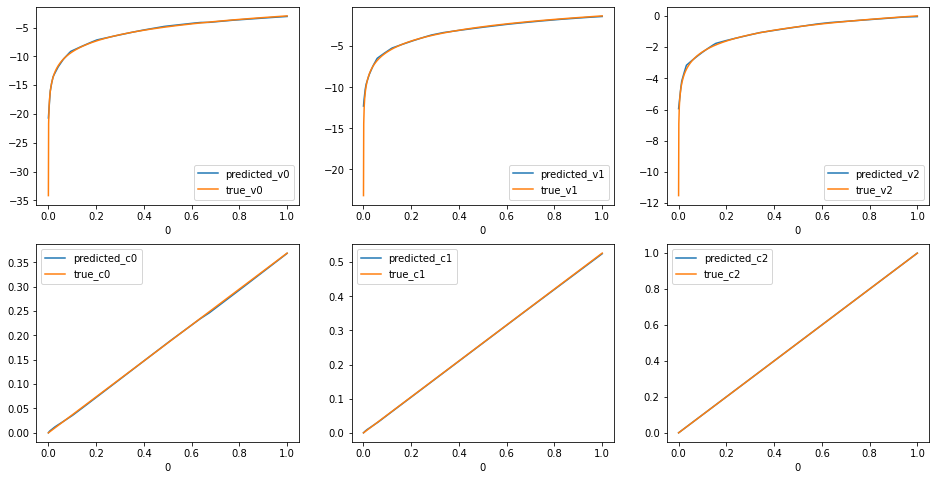

In [9]:
fig = plot_predictions(best_opt_state)

In [10]:
W = jnp.diag(jnp.array([1e1, 1e-1, 1., 0.])) # Weights on euler, bellman, foc, envelope, respectively
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, W=W, max_iter=5000)

Iteration: 100	Current Loss: 1.30e-01	Fair Loss: 9.82e-01	Average samples/s: 54549.69
Iteration: 200	Current Loss: 4.16e-02	Fair Loss: 3.85e-01	Average samples/s: 53842.10
Iteration: 300	Current Loss: 9.87e-03	Fair Loss: 2.93e-01	Average samples/s: 53927.65
Iteration: 400	Current Loss: 4.44e-02	Fair Loss: 3.67e-01	Average samples/s: 53963.61
Iteration: 500	Current Loss: 2.71e-02	Fair Loss: 4.37e-01	Average samples/s: 53676.12
Iteration: 600	Current Loss: 3.36e-02	Fair Loss: 4.09e-01	Average samples/s: 53369.84
Iteration: 700	Current Loss: 5.58e-02	Fair Loss: 5.89e-01	Average samples/s: 53341.99
Iteration: 800	Current Loss: 9.67e-02	Fair Loss: 5.92e-01	Average samples/s: 53216.80
Iteration: 900	Current Loss: 4.58e-02	Fair Loss: 4.85e-01	Average samples/s: 53098.49
Iteration: 1000	Current Loss: 3.45e-02	Fair Loss: 4.96e-01	Average samples/s: 52924.91
Iteration: 1100	Current Loss: 1.53e-02	Fair Loss: 3.26e-01	Average samples/s: 52969.21
Iteration: 1200	Current Loss: 2.16e-02	Fair Loss: 3.

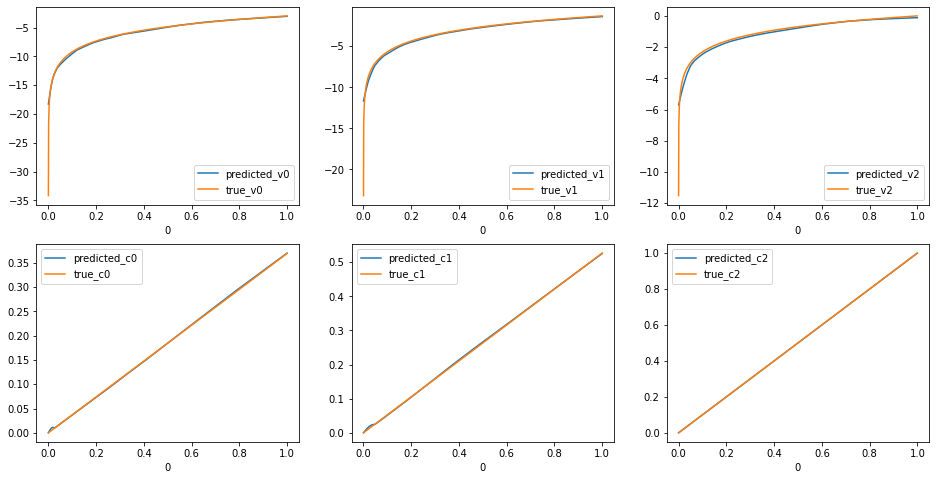

In [11]:
fig = plot_predictions(best_opt_state)

In [12]:
W = jnp.diag(jnp.array([1e1, 1e-1, 1., 1e-1])) # Weights on euler, bellman, foc, envelope, respectively
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, W=W, max_iter=5000)

Iteration: 100	Current Loss: 6.79e-01	Fair Loss: 3.20e+00	Average samples/s: 56357.00
Iteration: 200	Current Loss: 1.96e-01	Fair Loss: 1.21e+00	Average samples/s: 55960.25
Iteration: 300	Current Loss: 2.65e-01	Fair Loss: 1.07e+00	Average samples/s: 56438.56
Iteration: 400	Current Loss: 1.04e-01	Fair Loss: 5.85e-01	Average samples/s: 56467.38
Iteration: 500	Current Loss: 7.53e-02	Fair Loss: 4.46e-01	Average samples/s: 56308.79
Iteration: 600	Current Loss: 7.42e-02	Fair Loss: 4.19e-01	Average samples/s: 56323.31
Iteration: 700	Current Loss: 5.94e-02	Fair Loss: 4.09e-01	Average samples/s: 56218.09
Iteration: 800	Current Loss: 4.41e-01	Fair Loss: 1.84e+00	Average samples/s: 56124.55
Iteration: 900	Current Loss: 2.47e-01	Fair Loss: 8.70e-01	Average samples/s: 56080.07
Iteration: 1000	Current Loss: 1.56e-01	Fair Loss: 1.06e+00	Average samples/s: 56077.80
Iteration: 1100	Current Loss: 2.97e-01	Fair Loss: 1.29e+00	Average samples/s: 56092.00
Iteration: 1200	Current Loss: 1.88e-01	Fair Loss: 8.

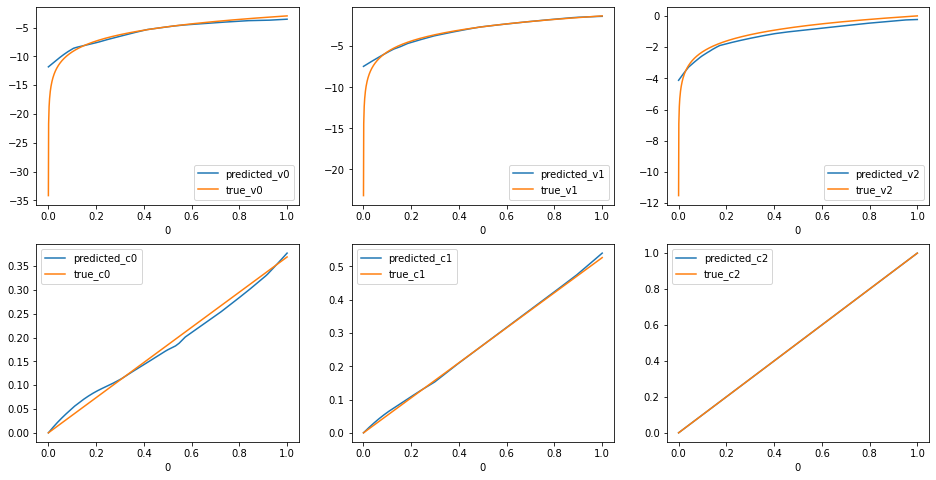

In [13]:
fig = plot_predictions(best_opt_state)

In [14]:
W = jnp.diag(jnp.array([0., 1., 1e1, 1e-2])) # Weights on euler, bellman, foc, envelope, respectively
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, W=W, max_iter=5000)

Iteration: 100	Current Loss: 8.71e+00	Fair Loss: 3.94e+00	Average samples/s: 56402.67
Iteration: 200	Current Loss: 8.80e+00	Fair Loss: 3.93e+00	Average samples/s: 56553.79
Iteration: 300	Current Loss: 8.61e+00	Fair Loss: 3.92e+00	Average samples/s: 56666.41
Iteration: 400	Current Loss: 8.65e+00	Fair Loss: 3.91e+00	Average samples/s: 56391.18
Iteration: 500	Current Loss: 8.59e+00	Fair Loss: 3.90e+00	Average samples/s: 56304.79
Iteration: 600	Current Loss: 8.71e+00	Fair Loss: 3.89e+00	Average samples/s: 56142.89
Iteration: 700	Current Loss: 8.50e+00	Fair Loss: 3.88e+00	Average samples/s: 56094.74
Iteration: 800	Current Loss: 8.60e+00	Fair Loss: 3.87e+00	Average samples/s: 55991.17
Iteration: 900	Current Loss: 8.81e+00	Fair Loss: 3.85e+00	Average samples/s: 55900.25
Iteration: 1000	Current Loss: 8.58e+00	Fair Loss: 3.84e+00	Average samples/s: 55947.21
Iteration: 1100	Current Loss: 8.67e+00	Fair Loss: 3.82e+00	Average samples/s: 55937.41
Iteration: 1200	Current Loss: 8.58e+00	Fair Loss: 3.

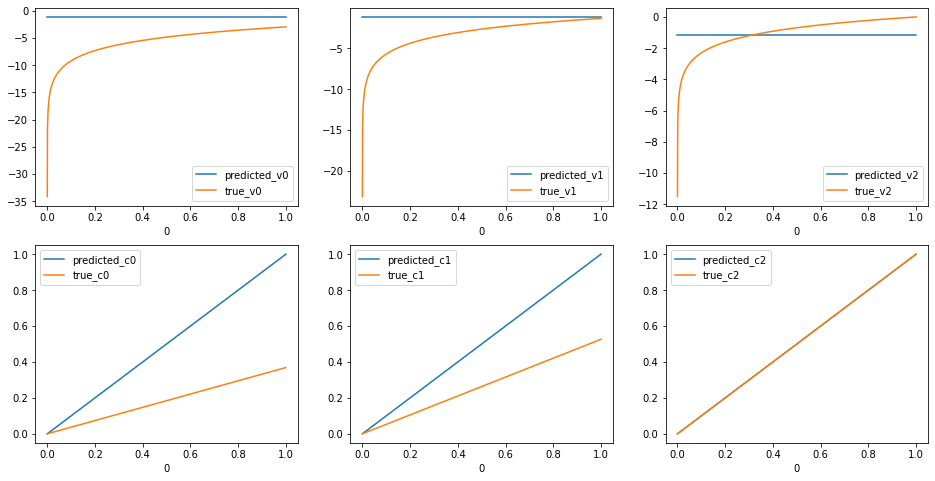

In [15]:
fig = plot_predictions(best_opt_state)

In [16]:
W = jnp.diag(jnp.array([0., 1., 1e1, 0.])) # Weights on euler, bellman, foc, envelope, respectively
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, W=W, max_iter=5000)

Iteration: 100	Current Loss: 7.62e+00	Fair Loss: 6.40e+00	Average samples/s: 56178.44
Iteration: 200	Current Loss: 4.49e+00	Fair Loss: 3.29e+00	Average samples/s: 55999.88
Iteration: 300	Current Loss: 4.04e+00	Fair Loss: 3.41e+00	Average samples/s: 56058.03
Iteration: 400	Current Loss: 1.13e+00	Fair Loss: 1.15e+00	Average samples/s: 55790.10
Iteration: 500	Current Loss: 3.09e-01	Fair Loss: 5.96e-01	Average samples/s: 55771.72
Iteration: 600	Current Loss: 2.53e-01	Fair Loss: 6.06e-01	Average samples/s: 55639.08
Iteration: 700	Current Loss: 1.92e-01	Fair Loss: 5.87e-01	Average samples/s: 55497.02
Iteration: 800	Current Loss: 2.30e-01	Fair Loss: 5.23e-01	Average samples/s: 55552.50
Iteration: 900	Current Loss: 2.47e-01	Fair Loss: 5.97e-01	Average samples/s: 55448.75
Iteration: 1000	Current Loss: 2.68e-01	Fair Loss: 4.73e-01	Average samples/s: 55505.52
Iteration: 1100	Current Loss: 2.17e-01	Fair Loss: 4.76e-01	Average samples/s: 55555.00
Iteration: 1200	Current Loss: 2.09e-01	Fair Loss: 5.

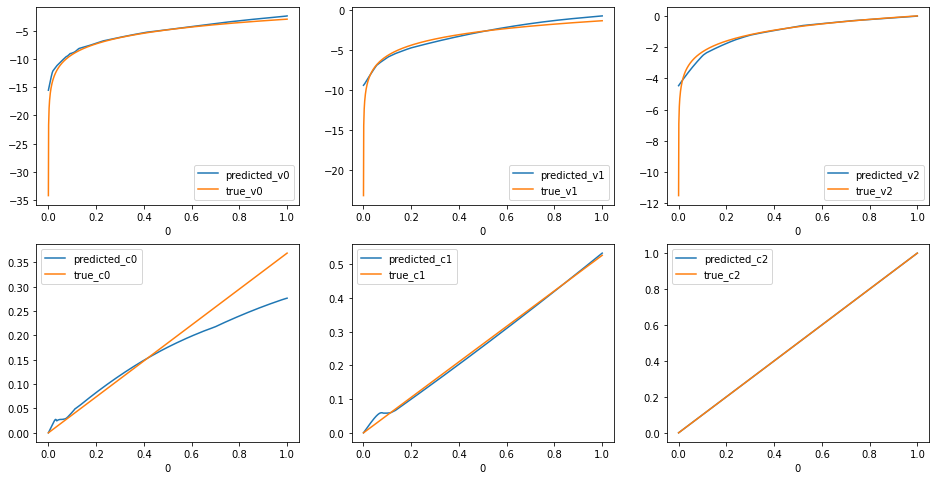

In [17]:
fig = plot_predictions(best_opt_state)